## Exploratory Data Analysis (EDA)

In [48]:
# Importing libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [49]:
# cleaning function

def warangle(filepath):
  # Importing the data
  df = pd.read_csv(filepath)

  # Converting the Cylinder column to type integer
  df['Cylinders'] = pd.to_numeric(df['Cylinders'], errors='coerce')

  # Filling the missing values
  imputer = KNNImputer(n_neighbors=4)
  df['Cylinders'] = imputer.fit_transform(df['Cylinders'].to_frame())

  # Dropping the "Description" column since it does'nt contribute much to model performance
  df = df.drop("Description", axis=1)

  # Combining the values with less than 200 counts into the "Other" category
  value_counts_make = df.Make.value_counts()
  common_values = value_counts_make[value_counts_make > 200].index
  df["Make"] = df.Make.apply(lambda x: x if x in common_values else "Other")

  # Combining the values with less than 100 in the "Model" column with "Other" category
  value_counts_model = df.Model.value_counts()
  filtered_models = value_counts_model[value_counts_model > 100].index
  df["Model"] = df.Model.apply(lambda x: x if x in filtered_models else "Other")

  # Combining the value counts with counts of less 20 in the "Location" with a  category as "Other"
  value_counts_Location = df["Location"].value_counts()
  filtered_locations = value_counts_Location[value_counts_Location > 20].index
  df["Location"] = df["Location"].apply(lambda x: x if x in  filtered_locations else "Other")

  # Encoding the categorical columns
  encoder = OrdinalEncoder()
  categorical_columns = df.select_dtypes("object").columns.to_list()
  df[categorical_columns] = encoder.fit_transform(df[categorical_columns])
  
    
  return df

In [50]:
# Loading the data
df = warangle(r"data\uae_used_cars_10k.csv")

In [51]:
# Overview of the data
df.head()

,Make,Model,Year,Price,Mileage,Body Type,Cylinders,Transmission,Fuel Type,Color,Location
0,14.0,1.0,2016,47819,156500,7.0,4.0,0.0,2.0,1.0,3.0
1,0.0,1.0,2013,61250,169543,6.0,4.0,0.0,2.0,7.0,0.0
2,0.0,1.0,2023,31861,221583,8.0,4.0,0.0,2.0,7.0,3.0
3,12.0,2.0,2016,110322,69754,7.0,4.0,0.0,2.0,11.0,3.0
4,14.0,1.0,2020,139994,71399,5.0,4.0,1.0,2.0,15.0,3.0


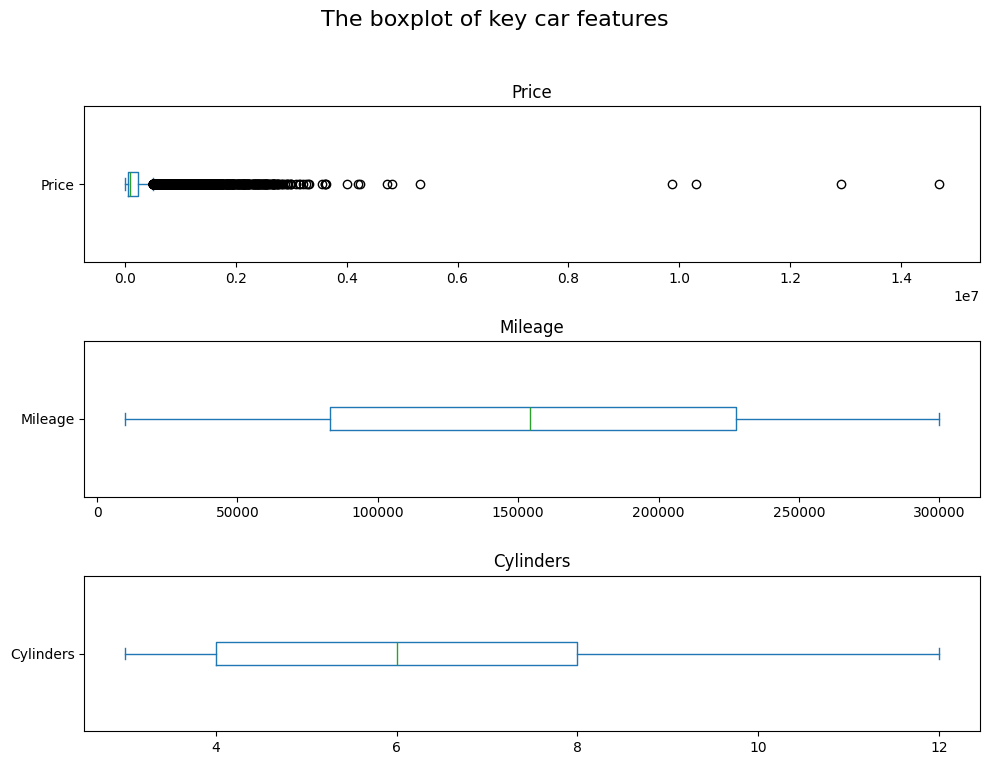

In [52]:
# checking for outliers in the dataset


# The "Price" column as a lot of the outliers
# in the dataset while the rest of the numerical columns have no outliers

# I will use log transformation onthe price column to reduce the effect of the skewed data

columns = ["Price", "Mileage", "Cylinders"]
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
fig.suptitle("The boxplot of key car features", fontsize=16)
ax.flatten()
for i, col in enumerate(columns):
  df[col].plot(kind="box", vert=False, ax=ax[i])
  ax[i].set_title(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

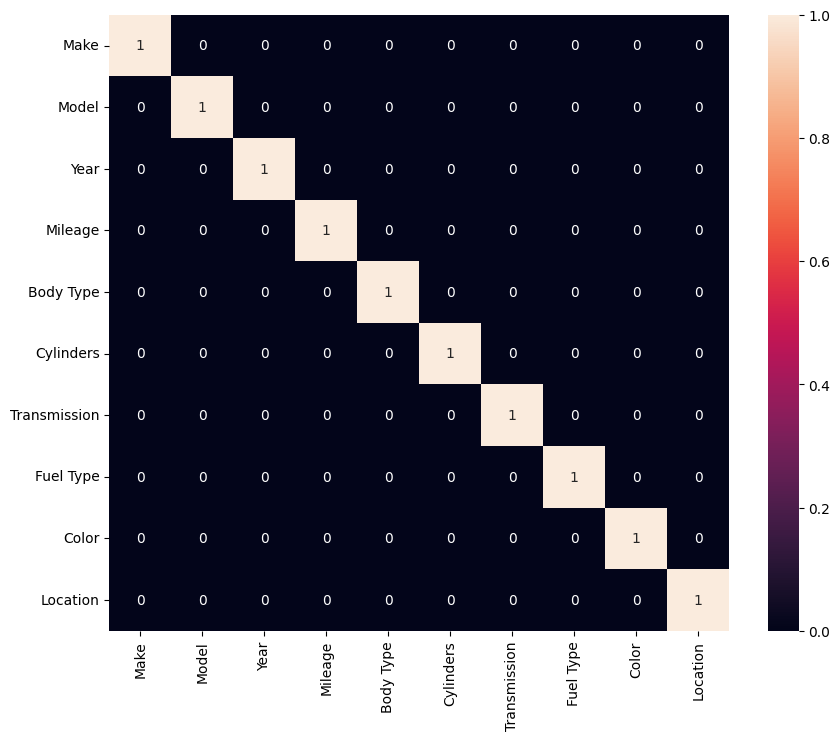

In [53]:
# Checking for the multicolinearity between the features

# All the columns are below the threshold of the correlation,
#therefore we are good to go.

threshold = 0.8
corr = df.drop(columns="Price").corr()>threshold
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True)
plt.show()

In [54]:
# Correlation of features with the target vector
corr_features = df.drop(columns="Price").columns.tolist()

target_feature_correlation = df[corr_features].corrwith(df["Price"])

pd.DataFrame(target_feature_correlation)

# print("#"*50)
# print("The features have no much correlation between themselves and the " \
# "'Make' column\nhas the a negative correlation with the target vector\nwhile the 'Cylinders' " \
# "column has the biggest positive correlation with the target vector  ")
# print("#"*50)

,0
Make,-0.150901
Model,0.026200
Year,0.000188
Mileage,0.010685
Body Type,-0.040483
Cylinders,0.446154
Transmission,-0.053886
Fuel Type,0.037254
Color,-0.069367
Location,0.011541


In [55]:
# I will take the log of the 'Price' column to reduce the effect of the skewed data
df["Log_price"] = np.log1p(df["Price"])

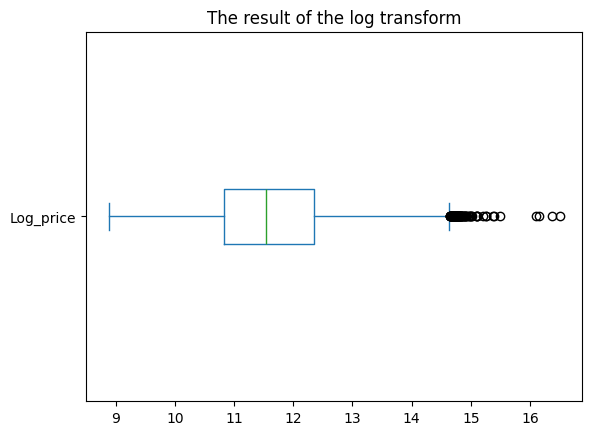

In [56]:
# The effect of the outliers is reduced by the log function
df["Log_price"].plot(kind="box", vert=False)
plt.title("The result of the log transform")
plt.show()

# I will have to drop the 'Price' to avoid the cheating the algorithm
df = df.drop("Price", axis=1)

## Feature Engineering

In [57]:
# Feature engineering of the Year column
current_year = date.today().year
car_year = df['Year']

df["car_age"] = current_year - car_year

In [58]:
# Current dataframe after feature engineering
df.head()

,Make,Model,Year,Mileage,Body Type,Cylinders,Transmission,Fuel Type,Color,Location,Log_price,car_age
0,14.0,1.0,2016,156500,7.0,4.0,0.0,2.0,1.0,3.0,10.775199,9
1,0.0,1.0,2013,169543,6.0,4.0,0.0,2.0,7.0,0.0,11.022735,12
2,0.0,1.0,2023,221583,8.0,4.0,0.0,2.0,7.0,3.0,10.369169,2
3,12.0,2.0,2016,69754,7.0,4.0,0.0,2.0,11.0,3.0,11.611168,9
4,14.0,1.0,2020,71399,5.0,4.0,1.0,2.0,15.0,3.0,11.849362,5


## Splitting the data
The data will be split into training and testing sets

In [59]:
# Features
X = df.drop(columns="Log_price")

# Target
y = df["Log_price"]

# training and testing data
X_train_split, X_test, y_train_split, y_test = train_test_split(X, y, train_size=0.8, random_state=256)

# Splitting the data into X_train and X_val sets
X_train, X_val, y_train, y_val = train_test_split(X_train_split, y_train_split, test_size=0.1, random_state=256) 

print("#"*70)
print(f"The shape of the feature matrix of the training set is: {X_train_split.shape}")
print(f"The shape of the target vector of the training set is: {y_train_split.shape} ")
print("-"*70)
print(f"The shape of the feature matrix of the test set is: {X_test.shape}")
print(f"The shape of the target vector of the test set is: {y_test.shape} ")
print("#"*70)

print(f"The shape of the X_train: {X_train.shape}")
print(f"The shape of the y_train: {y_train.shape} ")
print("-"*70)
print(f"The shape of X_val: {X_test.shape}")
print(f"The shape of y_val: {y_test.shape} ")
print("#"*70)

######################################################################
The shape of the feature matrix of the training set is: (8000, 11)
The shape of the target vector of the training set is: (8000,) 
----------------------------------------------------------------------
The shape of the feature matrix of the test set is: (2000, 11)
The shape of the target vector of the test set is: (2000,) 
######################################################################
The shape of the X_train: (7200, 11)
The shape of the y_train: (7200,) 
----------------------------------------------------------------------
The shape of X_val: (2000, 11)
The shape of y_val: (2000,) 
######################################################################


## Model training

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import root_mean_squared_error

In [61]:
# Dictionary of the models
reg = {
  "LR": LinearRegression(), 
  "RFR": RandomForestRegressor(),
  "XGB": XGBRegressor()
}

results = {}

for name, model in reg.items():
  score = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
  results[name] = score.mean()

results

{'LR': np.float64(0.26516951458178634),
 'RFR': np.float64(0.53869034166341),
 'XGB': np.float64(0.5189224001353291)}

In [62]:
# The best performing model is the RandomForestRegressor, the low performance of the model
# will be explained later

model = RandomForestRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [63]:
print(f"Performance on the training set: {round(model.score(X_train, y_train), 3)}")
print(f"Performance on the validation set: {round(model.score(X_val, y_val), 3)}")
root_mean_squared_error(y_val, y_pred)

# Model is overfitting on the data

Performance on the training set: 0.937
Performance on the validation set: 0.522


0.7537346658309629

In [64]:
k_range = range(1, 100, 2)
k_scores = []
for k in k_range:
  
  model = RandomForestRegressor(max_depth=k)
  model.fit(X_train, y_train)
  score = model.score(X_val, y_val)
  k_scores.append(score)

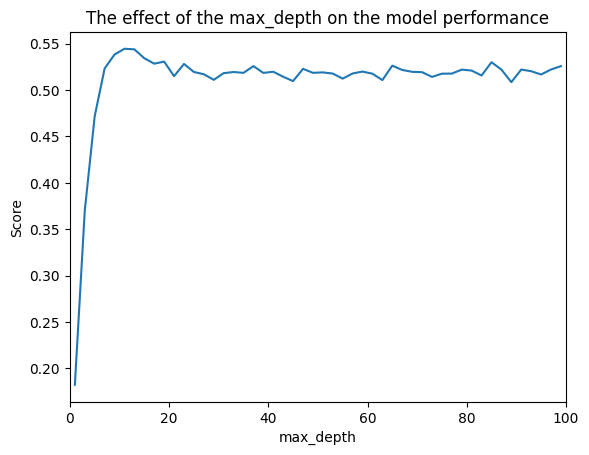

In [65]:
plt.plot(k_range, k_scores)
plt.title("The effect of the max_depth on the model performance")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.xlim(0, 100)
plt.show()

# I will the max_depth of 7 for the model to avoid overfitting the model

In [77]:
model = RandomForestRegressor(max_depth=7)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(f"Performance on the training set: {round(model.score(X_train, y_train), 3)}")
print(f"Performance on the validation set: {round(model.score(X_val, y_val), 3)}")
print(f"The root mean squared error is: {round(root_mean_squared_error(y_val, y_pred), 3)}")

Performance on the training set: 0.567
Performance on the validation set: 0.523
The root mean squared error is: 0.753


## Making prediction on the testing set

In [ ]:
# The prediction on the testing data
test_pred = model.predict(X_test) 

print(f"Performance on the validation set: {round(model.score(X_test, y_test), 3)}")
print(f"The root mean squared error is: {round(root_mean_squared_error(y_test, test_pred), 3)}")

Performance on the validation set: 0.521
The root mean squared error is: 0.77


In [96]:
# Saving the model
import joblib
joblib.dump(model, "car_prediction.pkl")

['car_prediction.pkl']

## Communication of the results

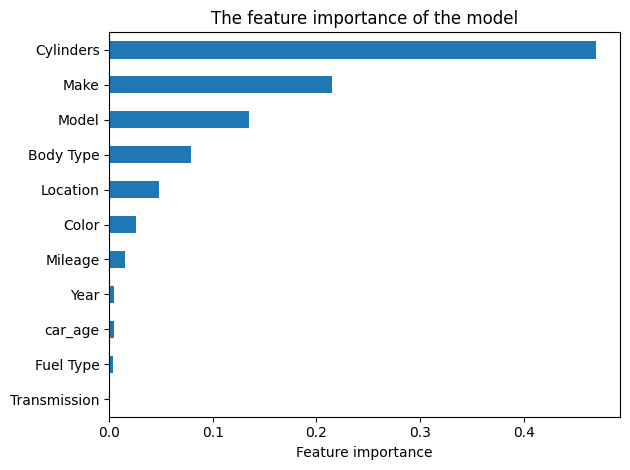

In [97]:
importance = model.feature_importances_
features = model.feature_names_in_

feature_importance = pd.Series(data=importance, index=features).sort_values(ascending=True)

feature_importance.plot(kind="barh")
plt.title("The feature importance of the model")
plt.xlabel("Feature importance")
plt.tight_layout()
plt.show()